# Test Trajectory Generator

Generate batch of trajectories, visualize waveforms and statistics

### Imports

In [46]:
import torch
import glob
import os
import soundfile as sf
import torchaudio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from model import DiffusionGenerator
from omegaconf import OmegaConf
from utilities.utilities import Eloi_Prettyfier as Prettyfier

### Setup

In [47]:
# Global
RESULTS_PATH = "../results/"
DATA_PATH = "../audio/"
SAVE_FIGS = True

# Target
TARGET = "Toy" # in ["Toy", "Real"]

# Batch
fs = 100
BATCH_SIZE = 256
SAMPLE_LENGTH = 512

assert TARGET in ["Toy", "Real"], "Choose either 'Toy' or 'Real' as TARGET"
if TARGET == "Toy":
    path_trajectories = f"{DATA_PATH}/ReelToReel_Dataset_MiniPulse100_CHOWTAPE_F[0.6]_SL[60]_TRAJECTORIES/Train"
    config = "../configs/conf_toytrajectories.yaml"
    MEAN_DELAY = 0.0271
    TICK_SPACING = 10        # in [ms]
    X_LIMS = [0.1, 50]
    X_TICKS = [0.1, 0.2, .5, 1, 2, 5, 10, 50, 50]
    LTAS_normalization = 0
else:
    path_trajectories = f"{DATA_PATH}ReelToReel_Dataset_Mini192kHzPulse100_AKAI_IPS[7.5]_MAXELL_TRAJECTORIES_SPLIT/Train"
    config = "../configs/conf_trajectories.yaml"
    MEAN_DELAY = 160.5 / 1e3 # in [s]
    TICK_SPACING = 0.25      # in [ms]
    X_LIMS = [1, 50]
    X_TICKS = [1, 2, 5, 10, 20, 50]
    LTAS_normalization = 40

# Trajectory Generation

Create trajectory generator and sample batch

In [48]:
# Create generator
args = OmegaConf.load(config)
args.diff_params.T = 10 # with kess steps, the output is somehow softer (over-denoised)
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = DiffusionGenerator(args, device)

# Generate batch
pred_batch = generator.sample_batch(BATCH_SIZE)
pred_batch += MEAN_DELAY

print(f"Generated trajectories (batch): {pred_batch.shape}")

# Generate single
# pred = generator.sample_long(10)
# pred += MEAN_DELAY

# print(f"Generated trajectories (single): {pred.shape}")

dict_keys(['it', 'network', 'optimizer', 'ema', 'args'])
Generated trajectories (batch): torch.Size([256, 512])


### Real Trajectories

Sample batch of real trajectories

In [49]:
# Load all wav files in the directory
orig_p = os.getcwd()
os.chdir(path_trajectories)
filelist = glob.glob("*.wav")
filelist = [os.path.join(path_trajectories, f) for f in filelist]
test_file = filelist[0]
os.chdir(orig_p)

# Sample batch
batch = torch.zeros((BATCH_SIZE, SAMPLE_LENGTH), device="cpu")
j = 0
while j < BATCH_SIZE:
    for a in filelist:
        if j >= BATCH_SIZE:
            break
        print(f"Processing {j+1}/{BATCH_SIZE} ...", end='\r')
        x, fs_file = sf.read(a)

        # Downsample to 100 Hz
        x = torch.from_numpy(x)
        if fs_file != fs:
            x = torchaudio.functional.resample(x, fs_file, fs)

        # Crop a 512 samples chunk
        for k in range(4):
            i = torch.randint(0, x.shape[0] - SAMPLE_LENGTH, (1,))
            batch[j] = x[i:i + SAMPLE_LENGTH]
            j += 1
print(f"Processing {j}/{BATCH_SIZE} ... Done!")

batch = batch - batch.mean(-1, keepdim=True) + MEAN_DELAY

print(f"Real trajectories: {batch.shape}")

Processing 256/256 ... Done!
Real trajectories: torch.Size([256, 512])


## Visualizations

### Waveform plot

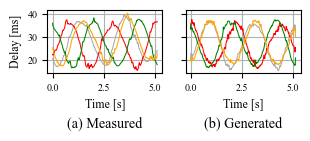

In [58]:
# Settings
FIG_MULTIPLIER = 1.0
COLS = 2
ROWS = 1
RATIO = (COLS * 2, 1)
NFFT = int(2**15)
PLOT_BATCH_SIZE = 4
labels_input = ["input, L", "input, R"]
labels_target = ["output, L", "output, R"]

prettyfier = Prettyfier(mode="paper_1col", ratio=RATIO)
prettyfier.font_size *= 0.95

ALPHA = prettyfier.alpha
DB_LIMS = prettyfier.db_lims

gs = plt.GridSpec(ROWS, COLS)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.rcParams['font.family'] = prettyfier.font_type
plt.rcParams['font.size'] = prettyfier.font_size
plt.rcParams['axes.labelsize'] = prettyfier.font_size * 6.0 / 6.0
plt.rcParams['xtick.labelsize'] = prettyfier.font_size * 5.0 / 6.0
plt.rcParams['ytick.labelsize'] = prettyfier.font_size * 5.0 / 6.0
plt.rcParams['lines.linewidth'] = prettyfier.line_width * 0.5

## Start plotting

t = np.arange(0, batch.shape[-1] / fs, 1 / fs)

fig = plt.figure(0, (prettyfier.fig_size[0] * FIG_MULTIPLIER,
                     prettyfier.fig_size[1] * FIG_MULTIPLIER))
fig.clf()

# Real trajectories
ax = fig.add_subplot(gs[0])

# Plot a batch of trajectories
# Randomize the order of the trajectories in batch
batch = batch[torch.randperm(batch.shape[0])]
for i in range(PLOT_BATCH_SIZE):
    ax.plot(t, 1000 * batch[i].flatten().numpy())

ax.set_title('(a) Measured', y=-1.0)
ax.set_xlabel('Time [s]')
ax.xaxis.set_major_locator(mpl.ticker.IndexLocator(base=2.5, offset=0))
ax.set_ylabel('Delay [ms]')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(TICK_SPACING))
y_lims = ax.get_ylim()
ax.grid()

# Generated trajectories
ax = fig.add_subplot(gs[1])

pred_batch = pred_batch[torch.randperm(pred_batch.shape[0])]
for i in range(PLOT_BATCH_SIZE):
    ax.plot(t, 1000 * pred_batch[i].flatten().numpy())

ax.set_title('(b) Generated', y=-1.0)
ax.set_xlabel('Time [s]')
ax.xaxis.set_major_locator(mpl.ticker.IndexLocator(base=2.5, offset=0))
# ax.set_ylabel('Delay [ms]')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(TICK_SPACING))
ax.set_ylim(y_lims)
ax.set_yticklabels([])
ax.grid()

# Limit space between subplots
# plt.subplots_adjust(hspace=0.7)
# plt.subplots_adjust(wspace=0.4)

plt.show()

if SAVE_FIGS:
    fig.savefig(f"{RESULTS_PATH}trajectories.pdf", bbox_inches='tight') # PDF
    fig.savefig(f"{RESULTS_PATH}trajectories.png", bbox_inches='tight') # PNG

### Statistics

Compute statistics

In [22]:
def LTAS(batch):
    """Compute the LTAS of a batch of trajectories."""
    # Setup
    batch_size = batch.shape[0]
    length = batch.shape[1]

    # Compute
    LTAS_batch = torch.zeros((batch_size, length // 2 + 1), device="cpu")
    for i in range(batch_size):
        LTAS_batch[i] = (torch.abs(torch.fft.rfft(batch[i])))

    # Take statistics
    LTAS_batch_mean = (LTAS_batch.mean(0))
    LTAS_std_top = LTAS_batch_mean + LTAS_batch.std(0)
    LTAS_std_bottom = LTAS_batch_mean - LTAS_batch.std(0)

    # Smoothing
    # LTAS_batch=torch.nn.functional.avg_pool1d(LTAS_batch.unsqueeze(0).unsqueeze(0), kernel_size=5, stride=1, padding=2, ceil_mode=False).squeeze()
    # Convert to dV
    # LTAS_batch_mean=20*torch.log10(LTAS_batch_mean)
    # LTAS_batch_std=20*torch.log10(LTAS_std)

    return 20 * torch.log10(LTAS_batch_mean), 20 * torch.log10(
        LTAS_std_top), 20 * torch.log10(LTAS_std_bottom)


print("Computing LTAS for real trajectories...", end='')
LTAS_mean, LTAS_std_up, LTAS_std_bottom = LTAS(batch - MEAN_DELAY)
print(" Done!")
print("Computing LTAS for generated trajectories...", end='')
pred_LTAS_mean, pred_LTAS_std_up, pred_LTAS_std_bottom = LTAS(pred_batch -
                                                              MEAN_DELAY)
print(" Done!")

# Normalize results
LTAS_mean += LTAS_normalization
LTAS_std_bottom += LTAS_normalization
LTAS_std_up += LTAS_normalization
pred_LTAS_mean += LTAS_normalization
pred_LTAS_std_up += LTAS_normalization
pred_LTAS_std_bottom += LTAS_normalization

Computing LTAS for real trajectories... Done!
Computing LTAS for generated trajectories... Done!


Plot statistics

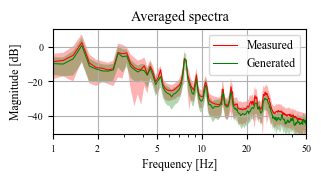

In [23]:
# SETUP
FIG_MULTIPLIER = 1.0
COLS = 1
ROWS = 1
RATIO = (1.75, 1)
NFFT = int(2**15)
PLOT_BATCH_SIZE = 4

prettyfier = Prettyfier(mode="paper_1col", ratio=RATIO)
prettyfier.font_size *= 0.95

ALPHA = prettyfier.alpha
DB_LIMS = prettyfier.db_lims

gs = plt.GridSpec(ROWS, COLS)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

labels_input = ["input, L", "input, R"]
labels_target = ["output, L", "output, R"]

plt.rcParams['font.family'] = prettyfier.font_type
plt.rcParams['font.size'] = prettyfier.font_size
plt.rcParams['axes.labelsize'] = prettyfier.font_size * 6.0 / 6.0
plt.rcParams['xtick.labelsize'] = prettyfier.font_size * 5 / 6.0
plt.rcParams['ytick.labelsize'] = prettyfier.font_size * 5 / 6.0
plt.rcParams['lines.linewidth'] = prettyfier.line_width * 0.5

# Start plotting

t = np.arange(0, batch.shape[-1] / fs, 1 / fs)
f = np.arange(0, fs / 2, fs / SAMPLE_LENGTH)

fig = plt.figure(0, (prettyfier.fig_size[0] * FIG_MULTIPLIER,
                     prettyfier.fig_size[1] * FIG_MULTIPLIER))
fig.clf()

# Real
ax = fig.add_subplot(gs[0, 0])

mu = LTAS_mean[0:-1].flatten().numpy()
sigma_bottom = LTAS_std_bottom[0:-1].flatten().numpy()
sigma_up = LTAS_std_up[0:-1].flatten().numpy()

ax.plot(f, mu, color="red", label="Measured")
ax.fill_between(f, sigma_up, sigma_bottom, facecolor='red', alpha=0.3)

# Generated
mu = pred_LTAS_mean[0:-1].flatten().numpy()
sigma_up = pred_LTAS_std_up[0:-1].flatten().numpy()
sigma_bottom = pred_LTAS_std_bottom[0:-1].flatten().numpy()

ax.plot(f, mu, color="green", label="Generated")
ax.fill_between(f, sigma_up, sigma_bottom, facecolor='green', alpha=0.3)

ax.set_title('Averaged spectra',)

ax.set_ylabel('Magnitude [dB]')
ax.set_ylim(-50, 10)
ax.set_xlabel('Frequency [Hz]')

ax.set_xscale("log")
ax.set_xlim(X_LIMS)
ax.set_xticks(X_TICKS)
ax.set_xticklabels(X_TICKS)

ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()

plt.show()

if SAVE_FIGS:
    fig.savefig("../results/spectra.pdf", bbox_inches='tight') # PDF
    fig.savefig("../results/spectra.png", bbox_inches='tight') # PNG